In [1]:
# 导入相关包 
import random
import numpy as np
import torch
from QRobot import QRobot
from ReplayDataSet import ReplayDataSet
from torch_py.MinDQNRobot import MinDQNRobot as TorchRobot # PyTorch版本
import matplotlib.pyplot as plt
from Maze import Maze
import time

In [2]:
class Robot(TorchRobot):
    def __init__(self, maze):
        """
        初始化 Robot 类
        :param maze:迷宫对象
        """
        super(Robot, self).__init__(maze)
        
        # destination 设置为和迷宫大小相关，为了在足够大的迷宫中，机器人也能「看得到」终点。
        maze.set_reward(reward={
            "hit_wall": 10.,
            "destination": -maze.maze_size ** 2 * 4.,
            "default": 1.,
        })
        self.maze = maze
        self.epsilon = 0
        """开启金手指，获取全图视野"""
        self.memory.build_full_view(maze=maze)
        
        # 初始化后即开始训练
        self.loss_list = self.train()
        

    def train(self):
        loss_list = []
        batch_size = len(self.memory)
        
        start = time.time()
        # 训练，直到能走出这个迷宫
        while True:
            loss = self._learn(batch=batch_size)
            loss_list.append(loss)
            self.reset()
            for _ in range(self.maze.maze_size ** 2 - 1):
                a, r = self.test_update()
                if r == self.maze.reward["destination"]:
                    print('Training time: {:.2f} s'.format(time.time() - start))
                    return loss_list


    def train_update(self):
        state = self.sense_state()
        action = self._choose_action(state)
        reward = self.maze.move_robot(action)

        """---update the step and epsilon---"""
        # self.epsilon = max(0.01, self.epsilon * 0.995)

        return action, reward
    
    
    def test_update(self):
        state = np.array(self.sense_state(), dtype=np.int16)
        state = torch.from_numpy(state).float().to(self.device)

        self.eval_model.eval()
        with torch.no_grad():
            q_value = self.eval_model(state).cpu().data.numpy()

        action = self.valid_action[np.argmin(q_value).item()]
        reward = self.maze.move_robot(action)
        return action, reward

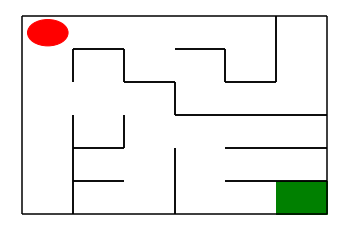

Maze of size (6, 6)
Training time: 1.72 s
{'hit_wall': 10.0, 'destination': -144.0, 'default': 1.0}
action: d reward: 1.0
action: d reward: 1.0
action: r reward: 1.0
action: r reward: 1.0
action: d reward: 1.0
action: r reward: 1.0
action: d reward: 1.0
action: d reward: 1.0
action: r reward: 1.0
action: r reward: -144.0
success


In [3]:
maze = Maze(maze_size=6) 
print(maze)

robot = Robot(maze=maze)

print(robot.maze.reward) # 输出最小值选择策略的reward值

"""Test Robot"""
robot.reset()
for _ in range(maze.maze_size ** 2 - 1):
    a, r = robot.test_update()
    print("action:", a, "reward:", r)
    if r == maze.reward["destination"]:
        print("success")
        break

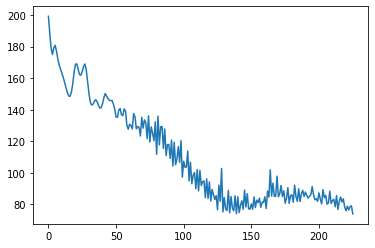

In [4]:
# 绘制损失曲线
loss_list = robot.loss_list
n = len(loss_list)
plt.plot(range(n), loss_list)